# Setting

In [0]:
import torch
from IPython.display import clear_output
!pip install transformers
from transformers import BertTokenizer, BertModel # `transformers` package
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torchtext 
import csv
import ctypes
csv.field_size_limit(int(ctypes.c_ulong(-1).value // 2))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

clear_output()

In [0]:
!pip install -U sentence-transformers

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.2.6.1)


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/pmldl-dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1hWFkWCBiGk6DFGbEIDgzXdKSS1kG5l20/pmldl-dataset


# Data Exploration

In [0]:
df = pd.read_csv('american-news-1.csv', header=None, names=['date', 'content'], nrows=2000)
df = df.dropna()
df.date = pd.to_datetime(df.date)
print(f'N articles: {len(df)}, start_date: {df.date.min()}, end_date: {df.date.max()} ')

N articles: 2000, start_date: 2018-01-01 04:28:00+02:00, end_date: 2018-01-30 22:33:00+02:00 


Word counts: Mean: 401.29, Max: 2625, Std: 304.2344176782108


(array([741., 706., 350., 125.,  64.,   9.,   3.,   1.,   0.,   1.]),
 array([   8. ,  269.7,  531.4,  793.1, 1054.8, 1316.5, 1578.2, 1839.9,
        2101.6, 2363.3, 2625. ]),
 <a list of 10 Patch objects>)

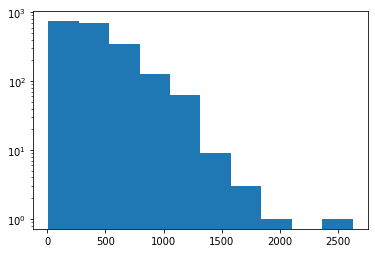

In [0]:
lens = list(map(lambda x: len(x.split(' ')), df['content'].array))
print(f'Word counts: Mean: {np.mean(lens)}, Max: {np.max(lens)}, Std: {np.std(lens)}')
plt.hist(lens, log=True)

In [0]:
len(list(filter((lambda x: x>512), lens)))/len(lens)

0.2965

## Torchtext dataset

In [0]:
import torchtext

131072

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
bert = BertModel.from_pretrained('bert-base-uncased').to(device)
print(max_input_length)


512


In [0]:
max_input_length = 512
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [0]:
target = pd.read_csv('target.csv')

In [0]:
target.columns

Index(['Emerging markets are set for an even bigger rally in 2018, says one technician. 17 Hours Ago | 02:56 \nEmerging markets soared more than 33 percent in 2017, and Todd Gordon of TradingAnalysis.com says the rally won't stop. \nA big part of the rally in emerging markets, tracked by the emerging market ETF EEM , was a weak dollar. And given that Gordon still sees the inverse relationship between EEM and the dollar, measured in his charts by the dollar-tracking ETF UUP , he believes the U.S. currency will continue to help the group. \n"We have a falling U.S. dollar, which will support international and emerging market currencies and will give those EEM stocks a boost," Gordon said Tuesday on CNBC's "Trading Nation." The U.S. dollar in 2017 posted its worst annual performance in 14 years, while EEM saw its best performance since 2013. \nAs for how high the latter could go, Gordon says EEM has broken "resistance" at around $45, which was the ETF's 2014 highs. That $45 region is now w

In [0]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [0]:
TEXT = torchtext.data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

In [0]:
torch_text_dataset = torchtext.data.TabularDataset('target.csv', format='CSV', fields=[('text', TEXT)], skip_header=True)

In [0]:
text_iterator = torchtext.data.BucketIterator(torch_text_dataset, 16, shuffle=False, device=device)

# BERT 

In [0]:
!pip install -U sentence-transformers

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 573kB 3.8MB/s 
     |████████████████████████████████| 3.7MB 6.9MB/s 
     |████████████████████████████████| 890kB 20.5MB/s 
     |████████████████████████████████| 1.0MB 33.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=7aa04c33d535180fb3f2bdce2977ab7d677c257010dc71fa21a43e00930cb196
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=13b2b0fe447e1cb6537eca8df8fcaad5b10d045da507a41412fe5e829a19730f
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sentence-transformers sacremoses


In [0]:
import tqdm

i = 0
df = pd.DataFrame(data={'vectors':[], 'shapes': []})
for batch in tqdm.tqdm(text_iterator):
    i+=1
    vectors = []
    shapes = []
    with torch.no_grad():
      hidden = bert(batch.text)[0]
      np_hidden = hidden.tolist()
      shape = list(hidden.shape)
      np_hidden = list(np.reshape(np.array(np_hidden), (shape[0], -1)))
      vectors.extend(np_hidden)
      shapes.extend([shape[1:] for i in range(shape[0])])
      df = df.append(pd.DataFrame(data={'vectors':vectors, 'shapes': shapes}))
    if i%100 == 0 and i!=0:
      df.to_parquet(f'bert_vectors_{i}.parquet')
      df = pd.DataFrame(data={'vectors':[], 'shapes': []})
    clear_output()
df.to_parquet(f'bert_vectors_{i}.parquet')

  3%|▎         | 527/19119 [21:27<8:26:27,  1.63s/it]

KeyboardInterrupt: ignored

In [0]:
parquet_files = ['bert_vectors_900.parquet', 'bert_vectors_1800.parquet', 'bert_vectors_2700.parquet', 
                 'bert_vectors_900.parquet','bert_vectors_900.parquet', 'bert_vectors_900.parquet', 
                 'bert_vectors_900.parquet', 'bert_vectors_900.parquet', 'bert_vectors_900.parquet']

In [0]:
import pyarrow

In [0]:
df  = pyarrow.parquet.read_table('bert_vectors_900.parquet').

In [0]:
df = df.to_pandas()

In [0]:
import sys

In [0]:
sys.getsizeof(df)/1000

3110.424

# Model

In [0]:
import torch.nn as nn

In [0]:
embedding_dim = 768
article_hid_dim = 400
context_hid_dim = 200
n_financial_features = 5 # financial features: 5 , 32 (Channels)
fc1_hid = 200
fc2_hid = 100
n_companies = 32
class FinancePredictor(nn.Module):
  def __init__(self):
    super(FinancePredictor, self).__init__()
    self.lstm_article = nn.LSTM(embedding_dim, article_hid_dim, bidirectional=True)
    self.lstm_local = nn.LSTM(article_hid_dim*2, context_hid_dim)
    self.lstm_global = nn.LSTM(article_hid_dim*2, context_hid_dim)
    self.financial_conv = nn.Conv1(in_channels=n_companies, out_channels=n_companies, kernel_size=n_financial_features)
    self.fc1 = nn.Linear(context_hid_dim*2, fc1_hid)
    self.fc2 = nn.Linear(fc1_hid, fc2_hid)
    self.fc3 = nn.Linear(n_companies + fc2_hid, n_companies)
  def forward(self, local_news, global_news, financial_features):
    '''
    local_news: [b, n_articles, n_words, emb_size]
    global_news: [b, n_articles, n_words, emb_size]
    financial_features: [b, features, n_companies]
    '''
    local_news_repr = torch.tensor([self.lstm_article(local_news[i])[0] for i in range(local_news.shape[0])]) # TODO Too long
    global_news_repr = torch.tensor([self.lstm_article(global_news[i])[0] for i in range(global_news.shape[0])]) # TODO Too long
    local_context = self.lstm_article(local_news_repr)
    global_context = self.lstm_article(local_news_repr)
    context = torch.cat([local_context, global_context])
    financial_context = self.financial_conv(financial_features) # assume 32x1 shape
    context = nn.ReLU(self.f1(context)) 
    context = nn.ReLU(self.f2(context)) # fc2_hd x 1 shape
    total_context = torch.cat([context, financial_context]) # (32 + fc2_hid, 1) shape
    prediction = self.fc3(total_context) # replace with (32, 3) shape, not (32, 1) shape
    return prediction
  
    


NameError: ignored